<a href="https://colab.research.google.com/github/Pro-Developer-Luke/Taxi-Duration-Predictions-ML/blob/main/Taxi_Duration_Predictions_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import essential libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Upload Datasets
#from google.colab import files
#uploaded = files.upload();
from google.colab import drive
drive.mount("/content/drive")
trip_train = pd.read_csv('/content/drive/MyDrive/GoogleColab/Datasets/trip_train.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Get dataset column names and set as pandas dataframe table
train_columns = pd.DataFrame(trip_train.columns, columns=['Training Dataset Columns'])

# Display the dataframe of dataset
print("Training Dataset Columns:")
display(train_columns)

Training Dataset Columns:


,Training Dataset Columns
0,id
1,vendor_id
2,pickup_datetime
3,dropoff_datetime
4,passenger_count
5,pickup_longitude
6,pickup_latitude
7,dropoff_longitude
8,dropoff_latitude
9,store_and_fwd_flag


In [ ]:
# Delete then check duplicate rows in the dataset
trip_train = trip_train.drop_duplicates()
print("Training Dataset Duplicates:", trip_train.duplicated().sum())
# Delete then check for fields/records with null values
trip_train.dropna(inplace=True)
print("===--===\nMissing values in Training Dataset:\n", trip_train.isnull().sum())

Training Dataset Duplicates: 0
===--===
Missing values in Training Dataset:
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [ ]:
#Change trip dtypes
trip_train['pickup_datetime'] = pd.to_datetime(trip_train['pickup_datetime'])
trip_train['dropoff_datetime'] = pd.to_datetime(trip_train['dropoff_datetime'])
trip_train['store_and_fwd_flag'] = trip_train['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
#Check changes
print("\nTraining Data Types\n",trip_train.dtypes)


Training Data Types
 id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag           float64
trip_duration                  int64
dtype: object


In [ ]:
print(trip_train['passenger_count'].describe())  # Min - Max and Range
trip_train = trip_train[(trip_train['passenger_count'] > 0) & (trip_train['passenger_count'] <= 6)]
trip_train = trip_train[(trip_train['trip_duration'] > 60) &
                                      (trip_train['trip_duration'] < 3600)]

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64


In [ ]:

from sklearn.metrics.pairwise import haversine_distances
from math import radians

trip_train_sample = trip_train.sample(frac=0.2, random_state=42)  # Use 20% of data

# Convert lat/lon values to radians
trip_train_sample[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']] = \
    trip_train_sample[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].apply(lambda x: x.map(radians))

# compute Haversine distances
pickup_points = trip_train_sample[['pickup_latitude', 'pickup_longitude']].values
dropoff_points = trip_train_sample[['dropoff_latitude', 'dropoff_longitude']].values

# Calculate distances and store them in the dataset
trip_train_sample['trip_distance_km'] = np.array([
    haversine_distances([pickup, dropoff])[0][1] * 6371  # Multiply by Earth's radius (in km)
    for pickup, dropoff in zip(pickup_points, dropoff_points)
])

# Extract time-based features from pickup_datetime
trip_train_sample['hour'] = trip_train_sample['pickup_datetime'].dt.hour
trip_train_sample['day_of_week'] = trip_train_sample['pickup_datetime'].dt.dayofweek
trip_train_sample['month'] = trip_train_sample['pickup_datetime'].dt.month

# Log-transform trip duration for better prediction
trip_train_sample['log_trip_duration'] = np.log1p(trip_train_sample['trip_duration'])

# Select features and dependant variable
X = trip_train_sample[['vendor_id', 'passenger_count', 'trip_distance_km',
                       'hour', 'day_of_week', 'month']]
y = trip_train_sample['log_trip_duration']  # Use log-transformed trip duration

# Split into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
from sklearn.ensemble import RandomForestRegressor

#n_estimators = no.Decision Trees | max_depth = level max (reduces overfitting) | random_state = Seed Procedure (Produces the same model)
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_log = rf_model.predict(X_val)
y_pred = np.expm1(y_pred_log)  # Convert back from log scale

# Convert y_val back from log scale for evaluation
y_val_original = np.expm1(y_val)

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_val_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_original, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}") #Average error in seconds
print(f"R² Score: {r2}") #Overall score

Mean Squared Error (MSE): 103064.7027933521
Root Mean Squared Error (RMSE): 321.03691811589533
R² Score: 0.7026578602429151


In [ ]:
trip_train.head(100)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,NaN,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,NaN,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,NaN,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,NaN,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,NaN,435
...,...,...,...,...,...,...,...,...,...,...,...
96,id3333094,2,2016-06-02 23:34:00,2016-06-02 23:41:15,1,-73.973465,40.755230,-73.977364,40.742821,NaN,435
97,id2228940,1,2016-02-04 13:22:02,2016-02-04 13:40:30,1,-73.981865,40.758774,-73.970222,40.784142,NaN,1108
98,id2102594,1,2016-03-30 16:14:29,2016-03-30 17:01:33,1,-73.789841,40.643559,-73.970665,40.687279,NaN,2824
99,id0010677,1,2016-04-29 10:40:34,2016-04-29 10:53:23,2,-73.991974,40.749996,-73.977882,40.754894,NaN,769


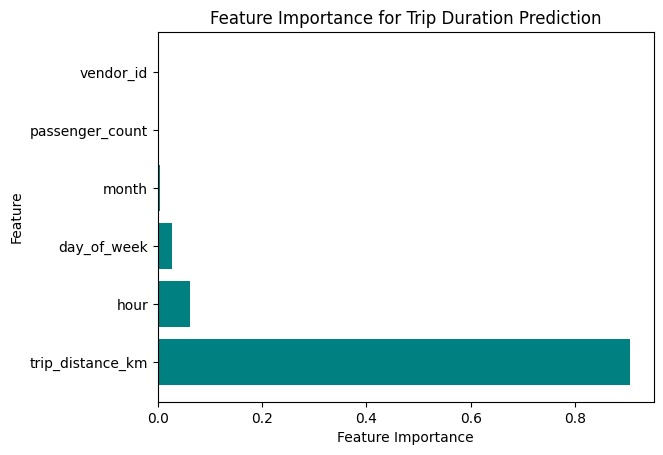

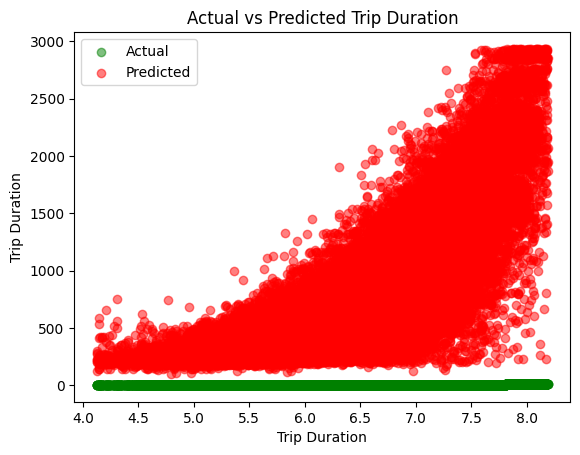

In [ ]:
# Get feature importances from the RandomForest model
importances = rf_model.feature_importances_

# Create a DataFrame to view the feature importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Trip Duration Prediction")
plt.show()

# Actual vs Predicted Trip Duration
plt.scatter(y_val, y_val, alpha=0.5, color='green', label='Actual')
plt.scatter(y_val, y_pred, alpha=0.5, color='red', label='Predicted')

plt.xlabel("Trip Duration")
plt.ylabel("Trip Duration")
plt.title("Actual vs Predicted Trip Duration")
plt.legend()
plt.show()